<IPython.core.display.Javascript object>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   specNum         1848 non-null   object
 1   final           1848 non-null   object
 2   interpretation  1848 non-null   object
dtypes: object(3)
memory usage: 43.4+ KB


<ipython-input-5-dbecb3929ac4>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['final'] = df1['final'].str.replace(r'\d+ *[a-z]{2}', ' ')
<ipython-input-5-6524d8c3205d>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['final'] = df1['final'].str.replace(r'[^\w\s]', ' ')
<ipython-input-5-49ab51a4aa02>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['final'] = df1['final'].str.replace(r'\d+', ' ')
<ipython-input-5-9cbf236ce26c>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df1['final'] = df1['final'].str.replace(r'\s+', ' ')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

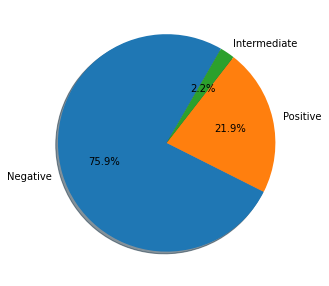

In [5]:
%run appV2_dataCleaning.ipynb

In [6]:
df

,specNum,final,interpretation,result
0,S18-33164,esophagus random biopsy no diagnostic abnormal...,Negative,0
1,N18-1798,urine collection method not specified negative...,Positive,1
2,S18-32678,uterus cervix bilateral fallopian tubes hyster...,Negative,0
3,N18-1801,cerebrospinal fluid tube negative for malignancy,Negative,0
4,S18-33316,colon descending biopsy no diagnostic abnormal...,Negative,0
...,...,...,...,...
1182,S18-33401,colon polyp rectum polypectomy polypoid coloni...,Intermediate,2
1183,F18-1364,salivary gland parotid left ultrasound guided ...,Negative,0
1184,S18-33581,gallbladder cholecystectomy chronic cholecysti...,Negative,0
1185,S18-33163,stomach site not otherwise specified biopsy ch...,Intermediate,2


In [17]:
#interesting tip:if chain format like tfidf= TfidfVectorizer(...).fit_transform() then 
#tfidf.get_feature_names doesnt work. However, if without chain like tfidf= TfidfVectorizer(...)
#tfidf.fit_transform(), then tfidf.get_feature_names works.

#conventional algor are often baised towards the majoirty class, not taking the data distribution into 
#consideration. One solution is to artificially balance the dataset for example oversampling each class. 

#classifier+learning algorithms can not directly process the text documents in their original form, 
#as most of them expect numerical feature vector with a fixed size rather than the raw text documents with
#variable length. One common approach for extracting features from text is to use the bag of words model:
#where for each document the presence(and often the freq) of words is taken into consideration. 
#Specifically, for each term in our dataset, we will calculate a measure called Term Freq Inverse Document 
#Freq (tf-idf) to calculate a tf-idf vector for each of comments.  
#tfidf = TfidfVectorizer(tokenizer= lemma, min_df=5, lowercase = True, ngram_range=(1,2), stop_words='english')
#vect_vectorized = tfidf.fit_transform(df['comment']) 


In [3]:
import nltk
from nltk.stem import WordNetLemmatizer 

# Define the sentence to be lemmatized
sentence = "The striped bats are hanging on their feet for best"
lemmatizer = WordNetLemmatizer()
# Tokenize: Split the sentence into words
word_list = nltk.word_tokenize(sentence)
print(word_list)
#> ['The', 'striped', 'bats', 'are', 'hanging', 'on', 'their', 'feet', 'for', 'best']

# Lemmatize list of words and join
lemmatized_output = ' '.join([lemmatizer.lemmatize(w, 'v') for w in word_list])
print(lemmatized_output)

['The', 'striped', 'bats', 'are', 'hanging', 'on', 'their', 'feet', 'for', 'best']
The strip bat be hang on their feet for best


In [7]:
import pyforest
from nltk.stem import WordNetLemmatizer 
def lemma(text):
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(w,'v') for w in tokens]
    return lemmatized

In [9]:
#lemmatize the comment text instead of porter stemming


tfidf=TfidfVectorizer(tokenizer= lemma, min_df=3, lowercase = True, ngram_range=(1,2), stop_words='english')
features = tfidf.fit_transform(df.final).toarray()
labels = df.result
features.shape

interpretation_id_df = df[['interpretation', 'result']].sort_values('result')
interpretation_to_id = dict(interpretation_id_df.values)
id_to_interpretation = dict(interpretation_id_df[['result', 'interpretation']].values)

<IPython.core.display.Javascript object>

C:\Users\yaolsen\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [10]:
interpretation_to_id

{'Negative': 0, 'Positive': 1, 'Intermediate': 2}

In [8]:
#np.unique(features.ravel())
len(np.unique(features.ravel()))

<IPython.core.display.Javascript object>

20386

In [8]:
#each comment is represented by 3956 features, representing the tf-idf score for different unigrams and bigrams. 
features.shape

(1187, 2382)

In [9]:
# use chi2 to find the unigram/bigram terms that are the most correlated with each of the category:
from sklearn.feature_selection import chi2

N = 20
for interpretation, result in interpretation_to_id.items():
    features_chi2 = chi2(features, labels== result) #return chi2 and p values
    #indices = np.asarray(features_chi2).max(0).argsort() 
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]#tfidf has been fit and transformed.
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print(f'# {interpretation}') 
    ugrams = '\n. '.join(unigrams[-N:])
    print(f'  @@ Most correlated unigrams:\n. {ugrams}')   
    bgrams = '\n. '.join(bigrams[-N:])
    print(f'  @@ Most correlated bigrams:\n. {bgrams}')   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Negative
  @@ Most correlated unigrams:
. prostate
. high
. variant
. colon
. nodular
. differentiate
. invasion
. metastatic
. urothelial
. grade
. suggestive
. nod
. adenocarcinoma
. positive
. basal
. situ
. tumor
. consistent
. cell
. carcinoma
  @@ Most correlated bigrams:
. variant comment
. invasive squamous
. feature suggestive
. lymph nod
. biopsy invasive
. ductal carcinoma
. high grade
. specify negative
. situ comment
. guide needle
. carcinoma nodular
. negative high
. positive malignancy
. carcinoma negative
. carcinoma situ
. grade urothelial
. basal cell
. urothelial carcinoma
. squamous cell
. cell carcinoma


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Positive
  @@ Most correlated unigrams:
. needle
. prostate
. colon
. variant
. high
. nodular
. differentiate
. invasion
. metastatic
. nod
. urothelial
. grade
. adenocarcinoma
. positive
. basal
. situ
. tumor
. consistent
. cell
. carcinoma
  @@ Most correlated bigrams:
. nodular variant
. variant comment
. invasive squamous
. lymph nod
. biopsy invasive
. ductal carcinoma
. specify negative
. high grade
. situ comment
. guide needle
. carcinoma nodular
. negative high
. positive malignancy
. carcinoma negative
. carcinoma situ
. grade urothelial
. basal cell
. urothelial carcinoma
. squamous cell
. cell carcinoma


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Intermediate
  @@ Most correlated unigrams:
. ovaries
. splenectomy
. elevate
. reactive
. clinically
. clinical
. gastric
. myeloproliferative
. jak
. process
. effect
. early
. feature
. prolapse
. ferritin
. cytopathic
. gastropathy
. hpv
. thrombocytosis
. suggestive
  @@ Most correlated bigrams:
. organisms esophagus
. morphology thrombocytosis
. ferritin level
. myeloproliferative disorder
. correlate clinically
. gastric mucosa
. biopsy gastric
. pylori organisms
. cytopathic effect
. curettings squamous
. reactive gastropathy
. mucosa feature
. diagnostic hpv
. epithelium change
. change suggestive
. hpv cytopathic
. effect transformation
. gastropathy pylori
. suggestive diagnostic
. feature suggestive


### name features: top 20 features that have the largest tf-idf
classifier+learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vector with a fixed size rather than the raw text documents with variable length. One common approach for extracting features from text is to use the bag of words model: where for each document the presence(and often the freq) of words is taken into consideration. Specifically, for each term in our dataset, we will calculate a measure called Term Freq Inverse Document Freq (tf-idf) to calculate a tf-idf vector for each of comments.  

In [162]:
stop_words = {'those', 'on', 'own', '’ve', 'yourselves', 'around', 'between', 'four', 'been', 'alone', 'off', 'am', 'then', 'other', 'can', 'regarding', 'hereafter', 'front', 'too', 'used', 'wherein', '‘ll', 'doing', 'everything', 'up', 'onto', 'never', 'either', 'how', 'before', 'anyway', 'since', 'through', 'amount', 'now', 'he', 'was', 'have', 'into', 'because', 'not', 'therefore', 'they', 'n’t', 'even', 'whom', 'it', 'see', 'somewhere', 'thereupon', 'nothing', 'whereas', 'much', 'whenever', 'seem', 'until', 'whereby', 'at', 'also', 'some', 'last', 'than', 'get', 'already', 'our', 'once', 'will', 'noone', "'m", 'that', 'what', 'thus', 'myself', 'out', 'next', 'whatever', 'although', 'though', 'which', 'would', 'therein', 'nor', 'somehow', 'whereupon', 'besides', 'whoever', 'ourselves', 'few', 'did', 'without', 'third', 'anything', 'twelve', 'against', 'while', 'twenty', 'if', 'however', 'herself', 'when', 'may', 'ours', 'six', 'done', 'seems', 'else', 'call', 'perhaps', 'had', 'nevertheless', 'where', 'otherwise', 'still', 'within', 'its', 'for', 'together', 'elsewhere', 'throughout', 'of', 'others', 'show', '’s', 'anywhere', 'anyhow', 'as', 'are', 'the', 'hence', 'something', 'hereby', 'nowhere', 'latterly', 'say', 'does', 'neither', 'his', 'go', 'forty', 'put', 'their', 'by', 'namely', 'could', 'five', 'unless', 'itself', 'is', 'nine', 'whereafter', 'down', 'bottom', 'thereby', 'such', 'both', 'she', 'become', 'whole', 'who', 'yourself', 'every', 'thru', 'except', 'very', 'several', 'among', 'being', 'be', 'mine', 'further', 'n‘t', 'here', 'during', 'why', 'with', 'just', "'s", 'becomes', '’ll', 'about', 'a', 'using', 'seeming', "'d", "'ll", "'re", 'due', 'wherever', 'beforehand', 'fifty', 'becoming', 'might', 'amongst', 'my', 'empty', 'thence', 'thereafter', 'almost', 'least', 'someone', 'often', 'from', 'keep', 'him', 'or', '‘m', 'top', 'her', 'nobody', 'sometime', 'across', '‘s', '’re', 'hundred', 'only', 'via', 'name', 'eight', 'three', 'back', 'to', 'all', 'became', 'move', 'me', 'we', 'formerly', 'so', 'i', 'whence', 'under', 'always', 'himself', 'in', 'herein', 'more', 'after', 'themselves', 'you', 'above', 'sixty', 'them', 'your', 'made', 'indeed', 'most', 'everywhere', 'fifteen', 'but', 'must', 'along', 'beside', 'hers', 'side', 'former', 'anyone', 'full', 'has', 'yours', 'whose', 'behind', 'please', 'ten', 'seemed', 'sometimes', 'should', 'over', 'take', 'each', 'same', 'rather', 'really', 'latter', 'and', 'ca', 'hereupon', 'part', 'per', 'eleven', 'ever', '‘re', 'enough', "n't", 'again', '‘d', 'us', 'yet', 'moreover', 'mostly', 'one', 'meanwhile', 'whither', 'there', 'toward', '’m', "'ve", '’d', 'give', 'do', 'an', 'quite', 'these', 'everyone', 'towards', 'this', 'cannot', 'afterwards', 'beyond', 'make', 'were', 'whether', 'well', 'another', 'below', 'first', 'upon', 'any', 'none', 'many', 'serious', 'various', 're', 'two', 'less', '‘ve'}

In [22]:
from nltk.corpus import stopwords 
stopwords_english = stopwords.words('english') 
print('Stop words\n')
print(stopwords_english)

Stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

In [24]:
stopwords_english.remove('no')
 
print('Stop words\n')
print(stopwords_english)

Stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'not', 'only', 'own', 'same', 'so', 'th

In [97]:
#tfidf = TfidfVectorizer(tokenizer= lemma, min_df=3, lowercase = True, ngram_range=(1,2), stop_words='english')
#vect_vectorized = tfidf.fit_transform(df['final']) 
from sklearn.feature_extraction.text import CountVectorizer
vect_vectorized = CountVectorizer(tokenizer= lemma, min_df=3, ngram_range=(1, 1), analyzer='word', stop_words=stopwords_english).fit(df['final']) 

C:\Users\yaolsen\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
C:\Users\yaolsen\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'win', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [98]:
#sorted_tfidf_index = features.max(0).argsort()
#a bag names
feature_names = np.array(vect_vectorized.get_feature_names())
len(feature_names)

<IPython.core.display.Javascript object>

879

In [99]:
features = vect_vectorized.fit_transform(df.final).toarray()
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [100]:
labels = df.result

In [101]:
df1 = pd.DataFrame(features, columns = feature_names)
df1#.iloc[1:2, 300:350]
#df['carcinoma'][:20]
#df1.iloc[1,][400:450]
#df1.loc[0, 'no']

<IPython.core.display.Javascript object>

,abdomen,abdominal,aberrant,abnormality,absent,absolute,acinar,actinic,active,activity,...,wash,weakly,weight,well,white,within,without,wrist,yeast,zone
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1182,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1183,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1184,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1185,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [102]:
neg_records = features[labels == 0]
len(neg_records)
neg_terms = feature_names[np.sum(neg_records, axis=0).argsort()[::-1]][:40]
print(f'# Negative terms: \n {neg_terms}')

<IPython.core.display.Javascript object>

# Negative terms: 
 ['no' 'biopsy' 'see' 'malignancy' 'colon' 'leave' 'skin' 'right'
 'negative' 'comment' 'polypectomy' 'atypia' 'benign' 'tissue' 'dysplasia'
 'adenoma' 'abnormality' 'tubular' 'evidence' 'mucosa' 'fragment' 'polyp'
 'change' 'prostate' 'chronic' 'squamous' 'zone' 'mild' 'identify'
 'diagnostic' 'cervix' 'clock' 'present' 'needle' 'endometrium'
 'peripheral' 'ascend' 'transformation' 'blood' 'pathologic']


In [103]:
#neg_feature_names = feature_names[neg_records.max(0).argsort()[::-1]], name = 'feature_names' )
#neg_feature_names
neg_freq_df = pd.DataFrame(sorted(np.sum(neg_records, axis=0).tolist(), reverse = True)[:40], index = neg_terms)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#neg_freq = pd.Series(sorted(np.sum(neg_records, axis=0).tolist(), reverse = True)[:40], index = neg_terms)
#for i, v in neg_freq.items():
#    print(i, v)

In [106]:
pos_records = features[labels == 1]
len(pos_records)
pos_terms = feature_names[np.sum(pos_records, axis=0).argsort()[::-1]][:40]
print(f'# Positive terms: \n {pos_terms}')

<IPython.core.display.Javascript object>

# Positive terms: 
 ['biopsy' 'carcinoma' 'prostate' 'grade' 'right' 'leave' 'tumor' 'needle'
 'no' 'negative' 'tissue' 'see' 'malignancy' 'cell' 'nod' 'skin'
 'positive' 'invasion' 'lymph' 'comment' 'identify' 'benign' 'evidence'
 'invasive' 'atypia' 'core' 'present' 'adenocarcinoma' 'involvement'
 'margin' 'lateral' 'squamous' 'breast' 'type' 'node' 'consistent' 'situ'
 'score' 'margins' 'metastatic']


In [107]:
pos_freq_df = pd.DataFrame(sorted(np.sum(pos_records, axis=0).tolist(), reverse = True)[:40], index = pos_terms)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [108]:
both_df= pd.merge(neg_freq_df, pos_freq_df, left_index = True, right_index=True)

<IPython.core.display.Javascript object>

In [109]:
data = []
for i, (word, neg, pos) in enumerate(zip(both_df.index.values, both_df['0_x'].values, both_df['0_y'].values)): 
    data.append([word, neg, pos])
data

[['no', 565, 160],
 ['biopsy', 530, 316],
 ['see', 363, 139],
 ['malignancy', 296, 134],
 ['leave', 254, 191],
 ['skin', 224, 122],
 ['right', 210, 200],
 ['negative', 181, 153],
 ['comment', 177, 108],
 ['atypia', 164, 87],
 ['benign', 155, 105],
 ['tissue', 153, 153],
 ['evidence', 134, 99],
 ['prostate', 112, 225],
 ['squamous', 109, 67],
 ['identify', 91, 107],
 ['present', 83, 81],
 ['needle', 82, 176]]

`Use a scatter plot in inspect this table visually. Instead of plotting the raw coutns, we will plot it in the logarithmic scale to take into account the wide discrepancies btw the raw counts(e.g. 'no' has 3568 counts in the neg and only 2 in pos). the red line marks the boundary btw pos and neg areas. Words close to the red line can be classififed as neutral.`

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

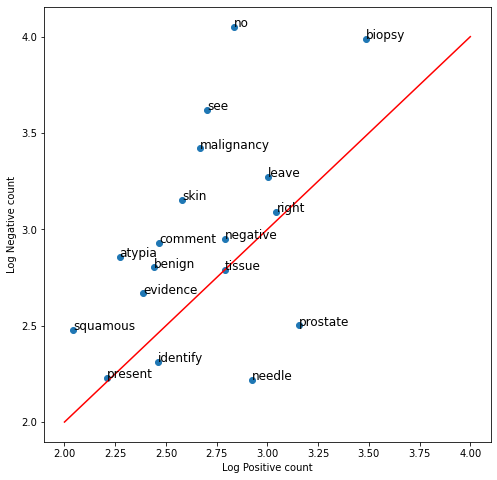

In [123]:
fig, ax = plt.subplots(figsize = (8, 8))
# convert pos raw counts to logarithmic scale. we add 1 to avoid log(0)
x = np.log([x[2]/10+1 for x in data])
#x = [x[2]*10 for x in data]
# do the same for the negative counts
y = np.log([x[1]/10+1 for x in data])
#y = [x[1]*10 for x in data]
#plot a dot for each pair of words
ax.scatter(x, y)

#assign axis labels
plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

#Add the word as the label as the same position as you added the points just before
for i in range(0, len(data)):
    ax.annotate(data[i][0], (x[i], y[i]), fontsize=12)

ax.plot([2, 4], [2, 4], color = 'red') #plot the red line that divides the 2 areas
plt.show()

In [170]:
#find out the most relevent unigram/bigram terms related to negative
features[labels == 1 ]
len(pos_records)
pos_feature_names = feature_names[pos_records.max(0).argsort()[::-1]] 
unigrams = [v for v in pos_feature_names if len(v.split(' ')) == 1]
bigrams = [v for v in pos_feature_names if len(v.split(' ')) == 2]
print(f'# Positive') 
ugrams = '\n. '.join(unigrams[: 40])
print(f'  @@ Most relevent unigrams:\n. {ugrams}') 
bgrams = '\n. '.join(bigrams[: 20])
print(f'  @@ Most relevent bigrams:\n. {bgrams}')   

# Positive
  @@ Most relevent unigrams:
. prostate
. nod
. tumor
. grade
. tissue
. lymph
. biopsy
. needle
. no
. atypia
. evidence
. malignancy
. benign
. negative
. margin
. carcinoma
. positive
. number
. renal
. invasive
. dcis
. present
. pelvic
. breast
. lateral
. invasion
. aortic
. involvement
. right
. adenocarcinoma
. score
. core
. leave
. identify
. edle
. gleason
. group
. colon
. perineural
. superficial
  @@ Most relevent bigrams:
. needle biopsy
. benign prostate
. no evidence
. malignancy prostate
. biopsy benign
. tissue no
. evidence atypia
. lymph nod
. atypia malignancy
. prostate tissue
. positive tissue
. tissue involvement
. biopsy adenocarcinoma
. core positive
. involvement perineural
. edle core
. prostate leave
. grade group
. adenocarcinoma grade
. score edle


In [20]:
pos_feature_names = pd.Series(feature_names[pos_records.max(0).argsort()[::-1]], name = 'feature_names' )
sorted_pos_value = pd.Series(sorted(pos_records.max(0).tolist(), reverse=True), name='tfidf', index = pos_feature_names)
#sorted_neg_value[:100].index
#unigrams = [v for v in sorted_neg_value.index if len(v.split(' ')) == 1]
#ugrams = '\n. '.join(unigrams[: 132])
#print(f'  @@ Most used unigrams:\n. {ugrams}') 
print(sorted_pos_value['carcinosarcoma'])
print(sorted_pos_value['carcinoma'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.5162449183848502
0.314131253631809


In [172]:
#find out the most relevent unigram/bigram terms related to negative
pos_records = features[labels == 0 ]
neg_feature_names = feature_names[neg_records.max(0).argsort()[::-1]] 
unigrams = [v for v in neg_feature_names if len(v.split(' ')) == 1]
bigrams = [v for v in neg_feature_names if len(v.split(' ')) == 2]
print(f'# Negative') 
ugrams = '\n. '.join(unigrams[: 40])
print(f'  @@ Most used unigrams:\n. {ugrams}') 
bgrams = '\n. '.join(bigrams[: 20])
print(f'  @@ Most used bigrams:\n. {bgrams}')  
#terms = '\n. '.join(neg_feature_names[:100])
#print(f'. {terms}')

# Negative
  @@ Most used unigrams:
. unspecified
. nutritional
. helix
. finger
. neutrophils
. leg
. tubulovillous
. gallbladder
. organisms
. aggregate
. kidney
. anatomic
. pression
. buttock
. field
. dermatofibroma
. frontal
. endometrium
. chest
. bowel
. resection
. low
. exact
. leave
. gland
. repair
. microangiopathic
. represent
. endometrial
. cholecystitis
. placenta
. rupture
. sac
. vaginal
. folliculitis
. necrotic
. term
. neutropenia
. endocervix
. pigment
  @@ Most used bigrams:
. biopsy atypical
. analysis negative
. leave breast
. cecum ascend
. right ovary
. colon random
. mammoplasty benign
. uninvolved tumor
. hyperplastic polyp
. mass excision
. breast partial
. biopsy melanoma
. ulceration satellite
. cyst excision
. granulation tissue
. level tumor
. esophagus biopsy
. keratosis skin
. endometrial polyp
. right shoulder


In [55]:
neg_feature_names = pd.Series(feature_names[neg_records.max(0).argsort()[::-1]], name = 'feature_names' )
sorted_neg_value = pd.Series(sorted(neg_records.max(0).tolist(), reverse=True), name='tfidf', index = neg_feature_names)
#sorted_neg_value[:100].index
#unigrams = [v for v in sorted_neg_value.index if len(v.split(' ')) == 1]
#ugrams = '\n. '.join(unigrams[: 132])
#print(f'  @@ Most used unigrams:\n. {ugrams}') 
print(sorted_neg_value['negative']) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.23552578103837193


In [14]:
#features now are all in a matrix. find max value along the rows. 
names = pd.Series(feature_names[vect_vectorized.max(0).toarray().ravel().argsort()], name = 'feature_names')

<IPython.core.display.Javascript object>

In [15]:
sorted_tfidf_value = pd.Series(sorted(vect_vectorized.max(0).toarray().ravel().tolist()), name='tfidf', index = names)

<IPython.core.display.Javascript object>

In [139]:
#vect_df = pd.concat([names, sorted_tfidf_value], axis=1)
#vect_df.set_index('feature_names') 

<IPython.core.display.Javascript object>

In [16]:
sorted_tfidf_value.nlargest(20) # katherine needs to be removed. 

feature_names
biopsy               1.000000
valve                0.784733
parathyroid          0.769012
thrombocytosis       0.748033
hemangioma           0.689648
finger               0.686502
nevus                0.658684
amputation           0.657479
leave cheek          0.657405
cd                   0.656424
scar                 0.653733
leiomyoma            0.652049
ulcer                0.649603
gallbladder          0.647710
partially            0.647265
colon polypectomy    0.643622
adrenal              0.629745
knee                 0.625595
analysis             0.616276
margin               0.615067
Name: tfidf, dtype: float64

In [17]:
names[names.str.contains('esophagu')]

484      identify esophagus
494        pylori esophagus
525         esophagus lower
625     organisms esophagus
727            esophagus ge
841     dysplasia esophagus
1128      barrett esophagus
1193       esophagus distal
1258     esophagus negative
1583    esophagus dysplasia
1678       esophagus middle
2155       esophagus biopsy
2219       esophagus random
2342              esophagus
Name: feature_names, dtype: object

In [18]:
sorted_tfidf_value[sorted_tfidf_value.index.str.contains('esophagu')]

feature_names
identify esophagus     0.175205
pylori esophagus       0.182879
esophagus lower        0.186541
organisms esophagus    0.207566
esophagus ge           0.226395
dysplasia esophagus    0.244131
barrett esophagus      0.283818
esophagus distal       0.292866
esophagus negative     0.300204
esophagus dysplasia    0.335369
esophagus middle       0.347362
esophagus biopsy       0.434442
esophagus random       0.451943
esophagus              0.538074
Name: tfidf, dtype: float64

In [174]:
#sorted_tfidf_value.index

In [ ]:
#historical code:
vect = TfidfVectorizer(lowercase = True, stop_words = 'english', ngram_range=(2,5) ).fit(df['comment'])
feature_names = np.array(vect.get_feature_names())
#transform the document into a do
vect_vectorized = vect.transform(df['comment']) 
sorted_tfidf_index = vect_vectorized.max(0).toarray().ravel().argsort()
names = pd.Series(feature_names[vect_vectorized.max(0).toarray().ravel().argsort()], name = 'feature_names')
sorted_tfidf_value = pd.Series(sorted(vect_vectorized.max(0).toarray().ravel().tolist()), name='tfidf')
vect_df = pd.concat([names, sorted_tfidf_value], axis=1)
small_df= vect_df.sort_values(by=['tfidf', 'feature_names']).iloc[:20,]
small_s=small_df['tfidf']
small_s.index=small_df['feature_names']
small_s.name=None
small_s.index.name=None
small_s
large_df = vect_df.sort_values(by=['tfidf', 'feature_names'], ascending = [False, True]).iloc[:20,] 
large_s = large_df['tfidf']
large_s.index=large_df['feature_names']
large_s.name = None
large_s.index.name = None

In [175]:
sorted_tfidf_value = pd.Series(sorted(vect_vectorized.max(0).toarray().ravel().tolist()), name='tfidf')

<IPython.core.display.Javascript object>

In [176]:
vect_df = pd.concat([names, sorted_tfidf_value], axis=1)

<IPython.core.display.Javascript object>

In [178]:
large_df = vect_df.sort_values(by=['tfidf', 'feature_names'], ascending = [False, True]).iloc[:20,] 

In [4]:
test_k = range(2, 100)[::5]
test_k 

range(2, 100, 5)